# Project Details: 

Build a Naive Bayes Model on Amazon Fine Food Reviews data set. Amazon Fine Food Reviews data set consists of reviews of fine foods from Amazon. <br>

Data source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

#Reviews                   : 568,454 
#Users                     : 256,059 
#Products                  : 74,258 
 Time Span                 : Oct 1999 - Oct 2012
#Attributes/Columns in set : 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2). It is binary classification task. Ignore review rating  = 3.


In [58]:
# ==================================================== Import Libraries ========================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3 # for importing data from sqlite database
import nltk #for Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer #for bag of words
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer # for term frequency/inverse document frequency of words
 # Model Performance measures
from sklearn.metrics import confusion_matrix , roc_curve, auc, accuracy_score, precision_recall_fscore_support
import re # References for Regular Expressions: https://docs.python.org/3/howto/regex.html, https://regexr.com/2vhbb
import warnings
from nltk.corpus import stopwords
from wordcloud import WordCloud
from gensim.models import Word2Vec
warnings.simplefilter('ignore')
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm_notebook as tqdm
import itertools

In [2]:
# =================================================== Importing Data ===========================================================
conn = sqlite3.connect('./database.sqlite')
print(conn.execute('select * from Reviews').description) #prints colnames in the table
df = pd.read_sql_query('Select * from Reviews where Score !=3',conn) #filtering neutral score = 3 from data

(('Id', None, None, None, None, None, None), ('ProductId', None, None, None, None, None, None), ('UserId', None, None, None, None, None, None), ('ProfileName', None, None, None, None, None, None), ('HelpfulnessNumerator', None, None, None, None, None, None), ('HelpfulnessDenominator', None, None, None, None, None, None), ('Score', None, None, None, None, None, None), ('Time', None, None, None, None, None, None), ('Summary', None, None, None, None, None, None), ('Text', None, None, None, None, None, None))


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# ============================================ Exploratory Data Analysis =====================================================
print(df.shape)
df['Score'] = df['Score'].apply(lambda x: 'Positive' if x > 3 else 'Negative') # Target Variable preparation
print(df.columns.groupby(df.dtypes))

(525814, 10)
{dtype('int64'): Index(['Id', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'], dtype='object'), dtype('O'): Index(['ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text'], dtype='object')}


In [5]:
sorted_data = df.sort_values(['UserId','Time'],ascending = True)
sorted_data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
125648,136323,B006Q820X0,#oc-R103C0QSV1DF5E,C,1,2,Positive,1343088000,Great for the Price,I have to say I was a little apprehensive to b...
477217,516062,B008I1XPKA,#oc-R109MU5OBBZ59U,AayGee,0,1,Positive,1350086400,AWESOME Coffee!!!!,Received my free K cups as a sample promotion ...
477233,516079,B008I1XPKA,#oc-R10LFEMQEW6QGZ,Julie,0,1,Positive,1345939200,Brooklyn Bean Roastery Breakfast Blend K-Cups,Brooklyn Bean Roastery Blend K-Cups are great ...
125844,136545,B006Q820X0,#oc-R10UA029WVWIUI,Kim D,0,0,Negative,1342483200,Less than satisfactory. I gave the Brooklyn K...,"Brooklyn ""French Roast"" K-Cup Coffee is not on..."
76583,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,Negative,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
166820,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,Negative,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
19935,21719,B005DVVB9K,#oc-R119LM8D59ZW8Y,"Lee Mellott ""SEOmenu2go""",5,11,Negative,1320192000,Not So Sweet Treat!,I love chocolate so I was excited to see the C...
268373,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,Positive,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
421207,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,Positive,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
459536,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,Positive,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


In [6]:
df.iloc[76583]

Id                                                                    83318
ProductId                                                        B005ZBZLT4
UserId                                                   #oc-R115TNMSPFT9I7
ProfileName                                                         Breyton
HelpfulnessNumerator                                                      2
HelpfulnessDenominator                                                    3
Score                                                              Negative
Time                                                             1331510400
Summary                           "Green" K-cup packaging sacrifices flavor
Text                      Overall its just OK when considering the price...
Name: 76583, dtype: object

In [7]:
df.iloc[166820]

Id                                                                   180872
ProductId                                                        B007Y59HVM
UserId                                                   #oc-R115TNMSPFT9I7
ProfileName                                                         Breyton
HelpfulnessNumerator                                                      2
HelpfulnessDenominator                                                    3
Score                                                              Negative
Time                                                             1331510400
Summary                           "Green" K-cup packaging sacrifices flavor
Text                      Overall its just OK when considering the price...
Name: 166820, dtype: object

There seems to be duplicate reviews given by same user at same time. These are due to MSKU (multi stock keeping units) products,
same product but are of different color/size, having different product ids as per Amazon catalogue. Say, there are 3 shirts 
of different colors (Red, Blue, Black) and all of them are sold by the same seller. In that case, Amazon lists them all in the 
same page under different product ids. Hence, a review comment on one of the shirt reflects the review comment in all the 
product ids. Hence, these are duplicated in the data. We need to remove such duplicates.

In [8]:
# de-duplication of data based on UserId,Time
dfinal = df.drop_duplicates(subset = {'UserId','ProfileName','Time'},keep='first',inplace = False)
dfinal.shape

(328771, 10)

In [9]:
#of duplicates in df
1-dfinal.size/df.size

0.37473897613985174

In [10]:
# Few other filters needed: #helpful comments cannot be more than the total comments
sum(dfinal.HelpfulnessNumerator > dfinal.HelpfulnessDenominator)

2

In [11]:
dfinal = dfinal[dfinal.HelpfulnessNumerator <= dfinal.HelpfulnessDenominator]

In [12]:
# Check for balance of classes
print(sum(dfinal['Score']=='Positive')/dfinal.shape[0])

0.8387439205034538


In [13]:
dfinal['Text'][1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

Text cannot be used as is, has to be converted into some numeric form (likes arrays or vectors of numbers) to be
used as feature in the model. But before that there is a need to process the text. 
1. Removing html tags (if any), since the urls does not add any information to the data.
2. Removing punctuations, non-alphanumeric characters. 
3. Need to lower/upper the cases so that 'Peanuts' & 'peanuts' are considered same.
4. Removing Stop words like which, what, whether, articles etc.
5. Removing text with <3 word length.
6. Stemming of words to its root/base word so that run, running, runs all considered to be same. 

In [14]:
# ===================================================Text Processing============================================================
## ==== UDFs====

def clean_html(text):
    tagsearch = re.compile('<.*?>')
    cleaned_txt = re.sub(tagsearch,' ',text)
    return(cleaned_txt)

def clean_pattern(text,pattern):
    cleaned_txt = re.sub(pattern,' ',text) #'[^a-zA-Z!]')
    #cleaned_txt = list(cleaned_txt)
    #cleaned_txt = [w.lower() for w in cleaned_txt.split() if len(w)>2]
    #cleaned_txt = ' '.join(cleaned_txt) 
    #print(cleaned_txt)
    return(cleaned_txt)

def exclamation_extract(x):
    em_words = []
    for i in x:
        em = re.findall(r"\w+!",i.lower())
        em_words.append(em)
    return em_words

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
stop = set(stopwords.words('english'))

Extracting words with exclamation marks in each review to see if we can make use of these words in favor of classification.
All positive exclamation words and negative exclamation words are gathered together. Rationale behind this is that we usually express our strong emotions using exclamation sentences or words. So, extracting exclamation sentences or words can help us identify the emotion of the customer.

In [15]:
em_positive = exclamation_extract(dfinal['Text'][dfinal['Score']=='Positive'])
em_positive = sum(em_positive,[])
em_negative = exclamation_extract(dfinal['Text'][dfinal['Score']=='Negative'])
em_negative = sum(em_negative,[])
em_words = exclamation_extract(dfinal['Text'])
dfinal['em_words'] = em_words
#em_positive = sum(em_positive,[])
#em_negative = sum(em_negative,[])
## gather all ! words to create word cloud

In [16]:
dfinal['em_words'] = dfinal['em_words'] .apply(lambda x: ' '.join(x))

In [17]:
pos = nltk.FreqDist(em_positive)
positives = pd.DataFrame({'emwords': list(pos.keys()),'count': list(pos.values())})

neg = nltk.FreqDist(em_negative)
negatives = pd.DataFrame({'emwords': list(neg.keys()),'count': list(neg.values())})

positives = positives.nlargest(columns = 'count', n =20)
negatives = negatives.nlargest(columns = 'count', n =20)

Plotting the top 20 positive and negative exclamation words with reference to their frequency of occurence in the reviews.
There are few emotions like great, delicious, good, again, enjoy, best, amazing etc. occuring in positive review comments
And emotions like Yuck, beware, awful, disappointed, horrible,wrong etc occuring in negative reviews. We can make use of such words to predict the state of review.

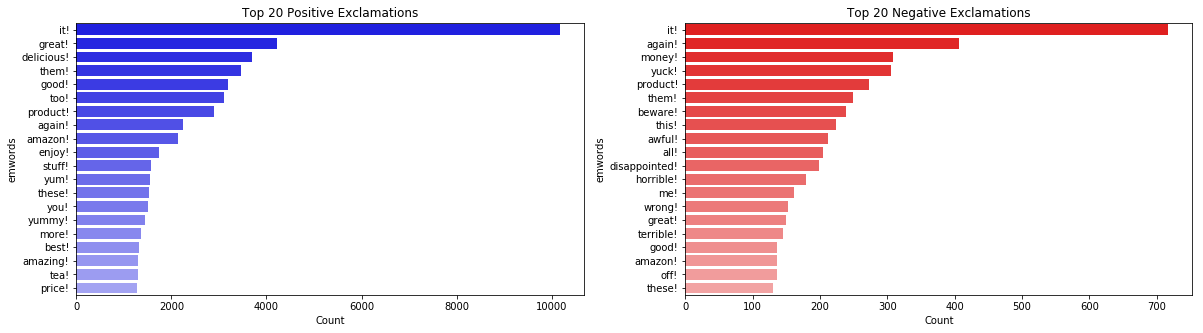

In [19]:
f, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=False)
sns.barplot(y ='emwords', x ='count',
            palette = sns.light_palette("blue", n_colors = 30, reverse = True),
            data = positives, 
            ax = axes[0])
axes[0].set(title = "Top 20 Positive Exclamations", xlabel = 'Count')
    
sns.barplot(y ='emwords', x ='count',
            palette = sns.light_palette("red", n_colors = 30, reverse = True),
            data=negatives, 
            ax=axes[1])
axes[1].set(title="Top 20 Negative Exclamations", xlabel = 'Count')

plt.show()

Processing of text and saving it in sqlite for ease of retrieval, to avoid unnecessary repetition of processing of data.

In [52]:
## Removing html, non-alphanumeric, len(words)<3,
cleaned_sent = []
cleaned_sent_w2v = []
final_string = []
final_string_w2v = []
positive_wrds = []
negative_wrds = []
i = 0
s = ''
for sent in dfinal['Text'].values:
    str_list = []
    w2v_str_list = []
    #phrases = re.compile(['[\w!]']).match(sent)
    sent = clean_html(sent) # removing html
    #print('1',sent)
    for w in clean_pattern(sent,'[^a-zA-Z]').split():
        #print(w)
        if(len(w)>2):
            w2v_str_list.append(w.lower())
            s = sno.stem(w.lower())
            str_list.append(s)
            if ((dfinal['Score'].values[i]=='Positive') & (w.lower() not in stop)):
                positive_wrds.append(w.lower())
            if ((dfinal['Score'].values[i]=='Negative') & (w.lower() not in stop)): 
                negative_wrds.append(w.lower())
        else:
            continue
    #print('2',str_list)
    cleaned_sent = " ".join(str_list)
    cleaned_sent_w2v = " ".join(w2v_str_list)
    final_string.append(cleaned_sent)
    final_string_w2v.append(cleaned_sent_w2v)
    i+=1
#print('3',final_string)
#print('4',final_string_w2v)
#print('5', positive_wrds)
#gather +ive, -ive words for word cloud

In [53]:
dfinal['cleaned_sent'] = final_string
dfinal['cleaned_sent_w2v'] = final_string_w2v
dfinal[-8:-7:]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,em_words,cleaned_sent,cleaned_sent_w2v
525804,568445,B001EO7N10,A2SD7TY3IOX69B,"BayBay ""BayBay Knows Best""",3,3,Positive,1245369600,Best Value for Chinese 5 Spice,"As a foodie, I use a lot of Chinese 5 Spice po...",price! great!,foodi use lot chines spice powder daili cook i...,foodie use lot chinese spice powder daily cook...


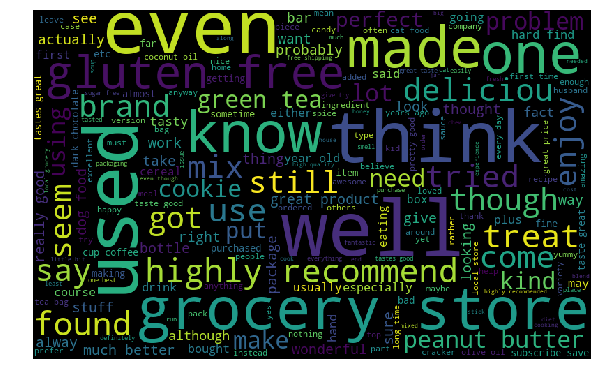

In [54]:
all_positive_words = ' '.join(positive_wrds)
all_negative_words = ' '.join(negative_wrds)
wordcloud = WordCloud(width = 800, height = 500, random_state = 3, max_font_size = 110,background_color = 'black').generate(all_positive_words)
plt.figure(figsize =(10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Saving all the extracts to sqlite for easy extract of data on refresh of this notebook

In [55]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
dfinal.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [2]:
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query('Select * from Reviews',conn) 
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,em_words,cleaned_sent,cleaned_sent_w2v
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,,have bought sever the vital can dog food produ...,have bought several the vitality canned dog fo...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,,product arriv label jumbo salt peanut the pean...,product arrived labeled jumbo salted peanuts t...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,,this confect that has been around few centuri ...,this confection that has been around few centu...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,,you are look for the secret ingredi robitussin...,you are looking for the secret ingredient robi...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,,great taffi great price there was wide assort ...,great taffy great price there was wide assortm...


Since, we have time in the data, we can make time based splitting of data into train and test.

In [3]:
## Time based Train, Test data
df = data.sort_values(by='Time')

train = df[:round(0.7*data.shape[0])]
test = df[round(0.7*data.shape[0]):]
#x_train,x_test,y_train,y_test = train_test_split(tr_tfidfw2v_features,train['label'], random_state = 3, test_size = 0.2)
print(df.shape)
print(train.shape)
print(test.shape)

(328769, 14)
(230138, 14)
(98631, 14)


In [4]:
## BOW: Bag of Words
count_vec = CountVectorizer(stop_words='english')
bow_words = count_vec.fit_transform(train['cleaned_sent'].values)
bow_words.shape

(230138, 57250)

In [5]:
np.isnan(bow_words.data).any()

False

In [6]:
## TF-IDF: Term Frequency-Inverse Document Frequency
tfidf_vec = TfidfVectorizer(stop_words = 'english',ngram_range=(1,2), max_df= 500, min_df = 2)
tfidf_words = tfidf_vec.fit_transform(train['cleaned_sent'])
tfidf_words.shape

(230138, 723876)

In [7]:
## Building Word2Vec model with train data
list_of_sent = [text.split() for text in train['cleaned_sent_w2v']]
w2v_model = Word2Vec(list_of_sent)

In [8]:
w2v_model.wv['great']

array([-0.4284515 ,  1.7969098 , -0.15125433, -0.87296903,  0.1949093 ,
       -0.12700321, -0.23230045, -1.4883986 , -0.47475475,  0.17626552,
       -2.3093395 ,  0.25216624, -0.42071226, -0.6216716 , -1.4158268 ,
        0.86309594,  1.0128536 ,  0.957995  , -0.41027334,  1.3927414 ,
        0.14235578, -0.7369642 ,  0.45793602,  2.1950269 ,  1.8480769 ,
        0.0783889 ,  1.4249749 ,  0.3067699 ,  0.8699451 , -1.6837889 ,
       -0.07728612, -0.60793155,  1.000988  ,  3.8713794 , -1.1344208 ,
       -2.76574   ,  2.76024   ,  3.462562  , -2.409702  ,  0.36534792,
        0.65664405, -0.5630747 ,  0.7557501 , -1.8285737 , -0.42611784,
        0.37162298, -1.3628058 ,  0.7324684 , -2.763756  ,  1.5828694 ,
        3.9181924 ,  0.98538804, -0.35004196,  0.1799824 , -0.31635845,
        0.92791647,  0.01294637,  0.37299427, -0.4658965 ,  2.900629  ,
        2.3969555 , -0.45612562, -1.7435952 ,  1.5684456 ,  1.7444319 ,
        1.1231743 ,  0.39362288, -1.752986  ,  0.35158092, -3.29

In [9]:
## Avg W2V - Average Word2Vec based features
sent_vectors = []
count = 0
for text in tqdm(df['cleaned_sent_w2v'].values):
    counter = 0
    sent_vec = np.zeros(100)
    for word in text.split():
        try:
            word_vec = w2v_model.wv[word]
            sent_vec += word_vec
            counter +=1
        except:
            count +=1
            pass
    sent_vec /= counter
    sent_vectors.append(sent_vec)
print('#of words not present in word2vec model built on train set is:', count)

HBox(children=(IntProgress(value=0, max=328769), HTML(value='')))


#of words not present in word2vec model built on train set is: 134445


In [14]:
train['avg_w2v'] = sent_vectors[:train.shape[0]] 
test['avg_w2v'] = sent_vectors[train.shape[0]:]

In [13]:
## TF-IDF W2V - Weighed average of word2vec based on tf-idf (weight) of the word
tfidfvec = TfidfVectorizer()
# give a matrix of all words, each cell represented by word has the tf-idf value
tfidfwords = tfidfvec.fit_transform(train['cleaned_sent_w2v']) 
dictionary = dict(zip(tfidfvec.get_feature_names(),list(tfidfvec.idf_))) # dict mapping of feature name as key and idf as value

list_of_sent = []
for sent in df['cleaned_sent_w2v'].values:
    list_of_sent.append(sent.split())

i = 0 # text row_id
tfidf_sent_vectors = []
for text in tqdm(list_of_sent):
    counter = 0
    sent_vec = np.zeros(100)
    tfidf_sent =0
    for word in text:
        try:
            word_vec = w2v_model.wv[word]
            tfidf_word = dictionary[word]*(text.count(word)/len(text))  # idf*tf
            sent_vec += word_vec*tfidf_word
            tfidf_sent += tfidf_word
        except:
            pass
    sent_vec /= tfidf_sent 
    tfidf_sent_vectors.append(sent_vec)
    i+=1

HBox(children=(IntProgress(value=0, max=328769), HTML(value='')))

In [15]:
train['tfidf_w2v'] = tfidf_sent_vectors[:train.shape[0]] 
test['tfidf_w2v'] = tfidf_sent_vectors[train.shape[0]:]

##### There is a fundamental assumption of Naive Bayes Model that all its features are independent and has no relation with each other. And Word2Vec featurization is built using word similarity or stresses on relationship between features. Hence, We cannot build a Naive Bayes model with Word2Vec based features.

In [16]:
# Check for balance of classes
print(sum(df['Score']=='Positive')/df.shape[0])

0.8387439205034538


The dataset seems to be highly biased (4 times) towards Positive reviews, and hence is an imbalanced dataset. Data needs to be
balanced to train a model. Or we can penalise the error on Negative review 4 times than error on Positive review to make model
learning unbiased.


Naive Bayes Model: It is a supervised, probability based model with a naive assumption that all features in the data set are 
independent of each other. Since, model is built on train, and if there are any outliers in test/validation set we use a hack
called Hyper-tuning parameter. Higher the value, higher the bias, underfitting is the model and viceversa. Hence, parameter 
tuning has to be done to ensure, the outliers in the data is dealt with as well model has decent accuracy (isn't either 
underfitting or overfitting).This can be done using Cross-Validation technique with different values of tuning parameters.

And since this is a time based cross validation, the constraint on Validation set is to be always future in nature, with reference to the training subset of the model.

Note: Read 'Test' as Validation set of the data.

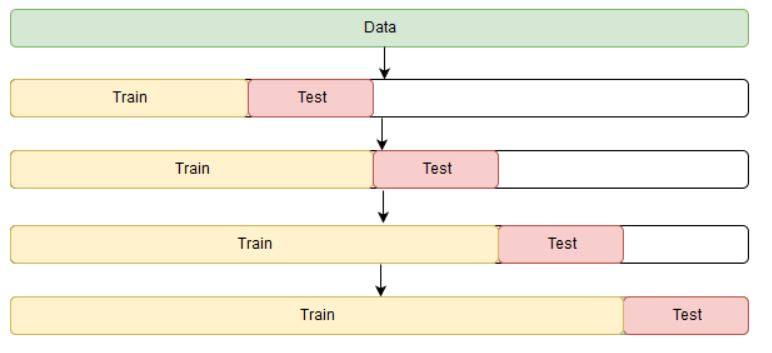



# Bag of Words Model

Let's build Naive Bayes model with Bag of words features built. Note that since we have taken frequency count of words while
building the Bag of words features, we need to use Multinomial Naive Bayes. On boolean frequency count of words we should build
Bernoulli Naive Bayes model.

In [99]:
# 10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(max_train_size= None, n_splits= 10)
X = bow_words
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
alpha = [0.0001,0.001,0.01,0.1,0,10,100,1000,10000] # tuning parameter: Laplace/Additive Smoothing
trcv_scores = []
tscv_scores = []
for i in alpha:
    classifier_name = MultinomialNB(alpha=i,fit_prior = False,class_prior = [0.5,0.5])
    for train_index, test_index in tscv.split(X):
        tsscore = []
        trscore = []
        train_x, test_x = X[train_index], X[test_index]
        train_y, test_y = Y[train_index], Y[test_index]
        modelNB = classifier_name.fit(train_x,train_y) 
        test_ypred = modelNB.predict(test_x)
        train_ypred = modelNB.predict(train_x)
        tsscore.append(accuracy_score(test_y,test_ypred,normalize = True)*100)
        trscore.append(accuracy_score(train_y,train_ypred,normalize = True)*100)
    trcv_scores.append(np.array(trscore).mean()) #averaging all the validation scores for each alpha value
    tscv_scores.append(np.array(tsscore).mean())      
best_alpha = alpha[tscv_scores.index(max(tscv_scores))]

To check the best tuning parameter, comparing the train and validation scores in a bias variance plot

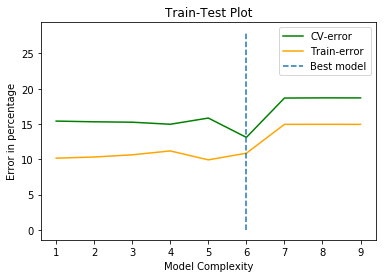

In [100]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x for x in tscv_scores]
tr_error = [100 - x for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(6,9),[0,3,5,8,10,12,16,17,28] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 10. So, picking up the best bag of words model with laplace smooting coefficient = 10.

In [84]:
# UDF for Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    
    title = 'Confusion matrix, without normalization'
    plt.figure(figsize=(20, 4))
    plt.subplot(1,2,1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
     
    title = "Normalized confusion matrix"
    plt.subplot(1,2,2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()   

In [108]:
# Checking accuracy of the model on test data
bow_words_tst = count_vec.transform(test['cleaned_sent'].values)
classifier_name = MultinomialNB(alpha = 10,class_prior=[0.5,0.5], fit_prior= False)
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Negative =1 ; Positive = 0
modelNB_bow = classifier_name.fit(bow_words,train_y)
predtest_y_bow = modelNB_bow.predict(bow_words_tst)

# Accuracy score
bow_acc = accuracy_score(test_y, predtest_y_bow, normalize=True)*100
print("Test Accuracy for NB model with bag of words:",bow_acc,'%')
# Precision-Recall, f-score
bow_pre, bow_recall, bow_fscore, bow_suprt = precision_recall_fscore_support(test_y,predtest_y_bow,pos_label = 1,\
                                                                             average = 'binary')
print("Test Precision for NB model with bag of words for Negative label reviews:",bow_pre)
print("Test Recall for NB model with bag of words for Negative label reviews:",bow_recall)
print("Test fscore for NB model with bag of words for Negative label reviews:",bow_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_bow, pos_label = 1)
bow_auc_score = auc(fpr,tpr)
print("Test AUC for NB model with bag of words:",bow_auc_score)
# Confusion matrix
bow_cm = confusion_matrix(test_y, predtest_y_bow)
#plot_confusion_matrix(bow_cm,normalize = True,test_y

Test Accuracy for NB model with bag of words: 87.67831614806704 %
Test Precision for NB model with bag of words for Negative label reviews: 0.8477622890682318
Test Recall for NB model with bag of words for Negative label reviews: 0.38859929376156044
Test fscore for NB model with bag of words for Negative label reviews: 0.5329182520465813
Test AUC for NB model with bag of words: 0.686594485350888


#### Observations :

1. Though the % Negative reviews caught are too low (39 %) but has high accuracy rate wrt negative predictions (85%). 
2. AUC is too low for the model.

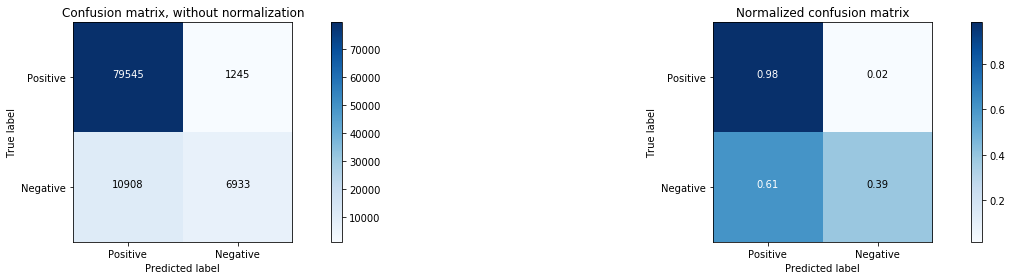

In [98]:
plot_confusion_matrix(bow_cm, ['Positive','Negative'])

#### Top 10 features of BOW - Naive Bayes Model

In [101]:
# UDF to print top 10 features of any Naive Bayes Model
def print_top10(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    for (coef_1, fn_1) in top:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))

In [102]:
# Top 10 features with Naive Bayes Model (in decreasing order of log probabilities)
print_top10(count_vec,modelNB_bow)

	-4.4806	tast           
	-4.5687	like           
	-4.7214	product        
	-5.0571	flavor         
	-5.1288	just           
	-5.1738	tri            
	-5.2025	veri           
	-5.3126	coffe          
	-5.3226	good           
	-5.3488	use            


# TF-IDF Naive Bayes Model

In [105]:
# 10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(max_train_size= None, n_splits= 10)
X = tfidf_words
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
alpha = [0.0001,0.001,0.01,0.1,0,10,100,1000,10000]
trcv_scores = []
tscv_scores = []
for i in alpha:
    classifier_name = MultinomialNB(alpha=i,fit_prior=False,class_prior=[0.5,0.5])
    for train_index, test_index in tscv.split(X):
        tsscore = []
        trscore = []
        train_x, test_x = X[train_index], X[test_index]
        train_y, test_y = Y[train_index], Y[test_index]
        modelNB = classifier_name.fit(train_x,train_y) 
        test_ypred = modelNB.predict(test_x)
        train_ypred = modelNB.predict(train_x)
        tsscore.append(accuracy_score(test_y,test_ypred,normalize = True)*100)
        trscore.append(accuracy_score(train_y,train_ypred,normalize = True)*100)
    trcv_scores.append(np.array(trscore).mean())
    tscv_scores.append(np.array(tsscore).mean())
        
best_alpha = alpha[tscv_scores.index(max(tscv_scores))]

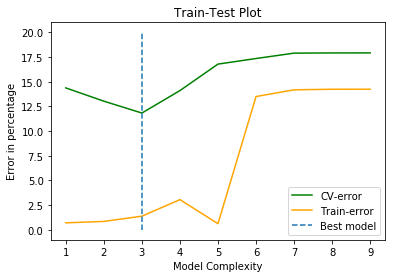

In [107]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x for x in tscv_scores]
tr_error = [100 - x for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(3,9),[0,3,5,8,10,12,16,17,20] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 0.01. So, picking up the model with 
laplace smooting coefficient = 0.01.

In [113]:
# Checking accuracy of the model on test data
tfidf_words_tst = tfidf_vec.transform(test['cleaned_sent'].values)
classifier_name = MultinomialNB(alpha = 0.01,fit_prior=False,class_prior=[0.5,0.5])
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
modelNB_tfidf = classifier_name.fit(tfidf_words,train_y)
predtest_y_tfidf = modelNB_tfidf.predict(tfidf_words_tst)

# Accuracy score
tfidf_acc = accuracy_score(test_y, predtest_y_tfidf, normalize=True)*100
print("Test Accuracy for NB model with TF-IDF:",tfidf_acc,'%')
# Precision-Recall, f-score
tfidf_pre, tfidf_recall, tfidf_fscore, tfidf_suprt = precision_recall_fscore_support(test_y,predtest_y_tfidf\
                                                                                     ,pos_label = 1, average = 'binary')
print("Test Precision for NB model with TF-IDF for Positive label reviews:",tfidf_pre)
print("Test Recall for NB model with TF-IDF for Positive label reviews:",tfidf_recall)
print("Test fscore for NB model with TF-IDF for Positive label reviews:",tfidf_fscore)
# ROC, AUC
tfidf_fpr, tfidf_tpr, tfidf_thresholds = roc_curve(test_y,predtest_y_tfidf, pos_label = 1)
tfidf_auc_score = auc(tfidf_fpr,tfidf_tpr)
print("Test AUC for NB model with TF-IDF:",tfidf_auc_score)
# Confusion matrix
tfidf_cm = confusion_matrix(test_y, predtest_y_tfidf)

Test Accuracy for NB model with TF-IDF: 89.36237085703279 %
Test Precision for NB model with TF-IDF for Positive label reviews: 0.7258867646154792
Test Recall for NB model with TF-IDF for Positive label reviews: 0.6618463090633933
Test fscore for NB model with TF-IDF for Positive label reviews: 0.6923888823736367
Test AUC for NB model with TF-IDF: 0.8033269173736325


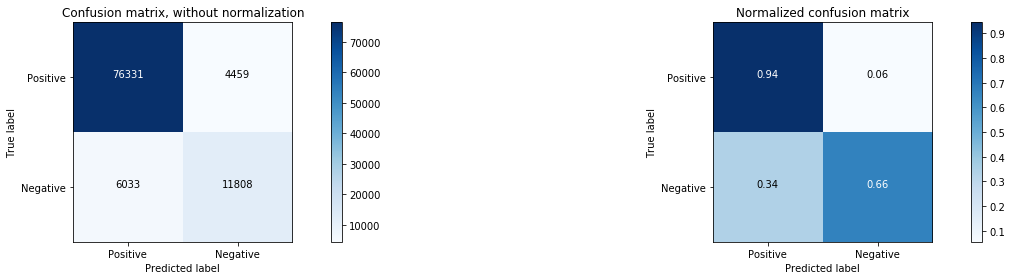

In [114]:
plot_confusion_matrix(tfidf_cm, ['Positive','Negative'])

#### Observations:

1. Precision has come down from 84% to 72% but the recall rate has improved a lot with the TFIDF based NB model.
2. AUC is good for the model (80%)

In [110]:
# Top 10 features with Naive Bayes Model
print_top10(count_vec,modelNB_tfidf,n=10)

	-8.3894	prefrozen      
	-8.4159	podravka       
	-9.0251	organza        
	-9.0329	incisor        
	-9.1617	vecchia        
	-9.1624	microorgan     
	-9.1844	uncrush        
	-9.2316	vapid          
	-9.2773	simplehuman    
	-9.4081	lalabar        


## Conclusion:

In [145]:
table = [["Bag Of Words", bow_acc, bow_pre,bow_recall, bow_fscore,bow_auc_score],
         ["TF-IDF", tfidf_acc, tfidf_pre,tfidf_recall,tfidf_fscore,tfidf_auc_score]]
pd.DataFrame(table, columns = ["Model","Accuracy", "Precision", "Recall","f-score","AUC"])

,Model,Accuracy,Precision,Recall,f-score,AUC
0,Bag Of Words,87.678316,0.847762,0.388599,0.532918,0.686594
1,TF-IDF,89.362371,0.725887,0.661846,0.692389,0.803327


Naive Bayes Model is a simple yet powerful model which takes a naive assumption that all the features are independent or 
or uncorelated to each other. The best accuracy that we could get using Naive Bayes is 89%. The Naive Bayes Model built with Term Frequency- Inverse Document Frequency vectors seems to be the best of all with an AUC of 80%. We can keep this as baseline measure for other algorithms.